# Setup

In [ ]:
import warnings

import numpy as np
from matplotlib import pyplot as plt

from compare_variance_residual.simulated.plotting import plot_predicted_contributions_box, plot_prediction_error, \
    plot_prediction_scatter
from compare_variance_residual.simulated.simulation import run_experiment

warnings.simplefilter(action='ignore')
plt.style.use('ggplot')

In [2]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

In [3]:
def plot_experiment(variable_values, variable_name, predicted_variance, predicted_residual, n_runs,
                    unique_contributions, n_features_list, n_targets, n_samples_train, n_samples_test, noise_level,
                    random_distribution, ignore_negative_r2, use_refinement, use_ols, x_is_log=False):
    variable_infos = dict(n_runs=n_runs, n_features_list=n_features_list,
                          n_targets=n_targets, n_samples_train=n_samples_train, n_samples_test=n_samples_test,
                          noise_level=noise_level, random_distribution=random_distribution,
                          ignore_negative_r2=ignore_negative_r2, use_refinement=use_refinement, use_ols=use_ols)

    plot_predicted_contributions_box(variable_values, variable_name, predicted_variance, predicted_residual,
                                     unique_contributions, x_is_log=x_is_log, **variable_infos)
    plot_prediction_error(variable_values, variable_name, predicted_variance, predicted_residual,
                          unique_contributions, x_is_log=x_is_log, **variable_infos)
    plot_prediction_scatter(variable_values, variable_name, predicted_variance, predicted_residual,
                            unique_contributions, **variable_infos)

# Set default values to be used in the tests

In [4]:
n_observations = 5

variables = dict(
    n_runs=3,
    unique_contributions=[0.5, 0.3],
    n_features_list=[100, 100],
    n_targets=100,
    n_samples_train=100,
    n_samples_test=100,
    noise_level=0.0,
    random_distribution="normal",

    ignore_negative_r2=True,
    use_refinement=False,
    use_ols=False,
)

# Varying distributions

In [5]:
variable_name = "sampling distributions"
random_distributions = ["normal", "uniform", "exponential", "gamma", "beta", "poisson", "lognormal", "pareto"]

In [6]:
predicted_variance, predicted_residual = run_experiment(random_distributions, variable_name, **variables)

[........................................] 100% | 6.00 sec | Varying sampling distributions | 


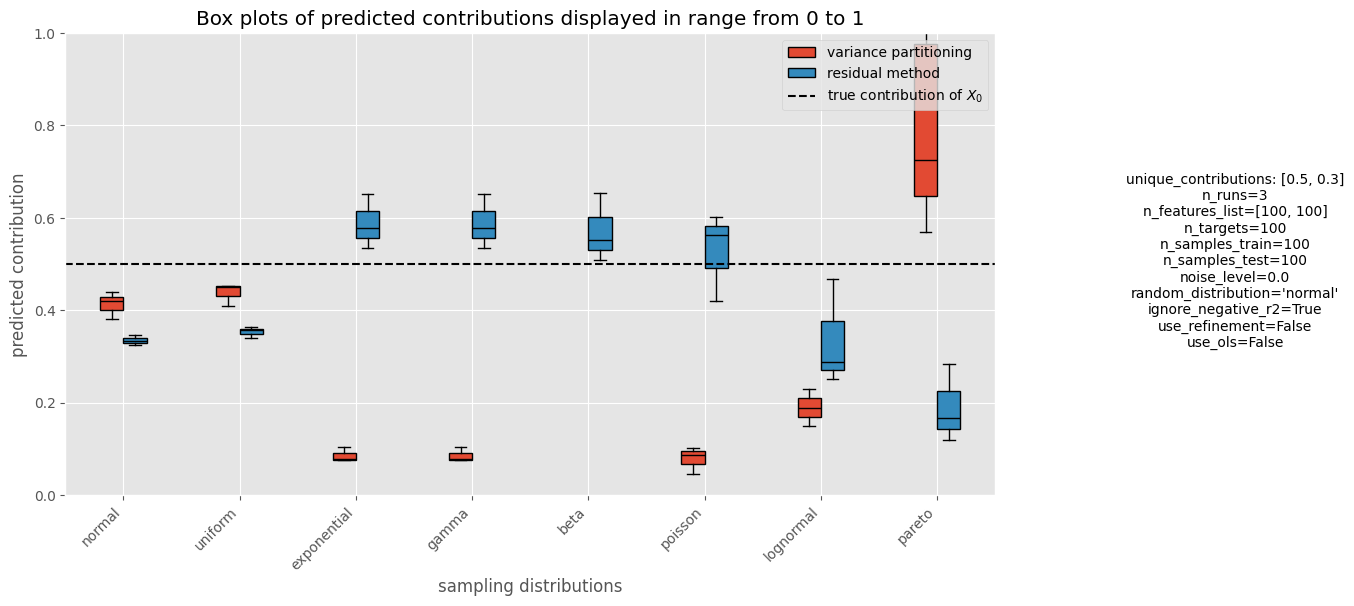

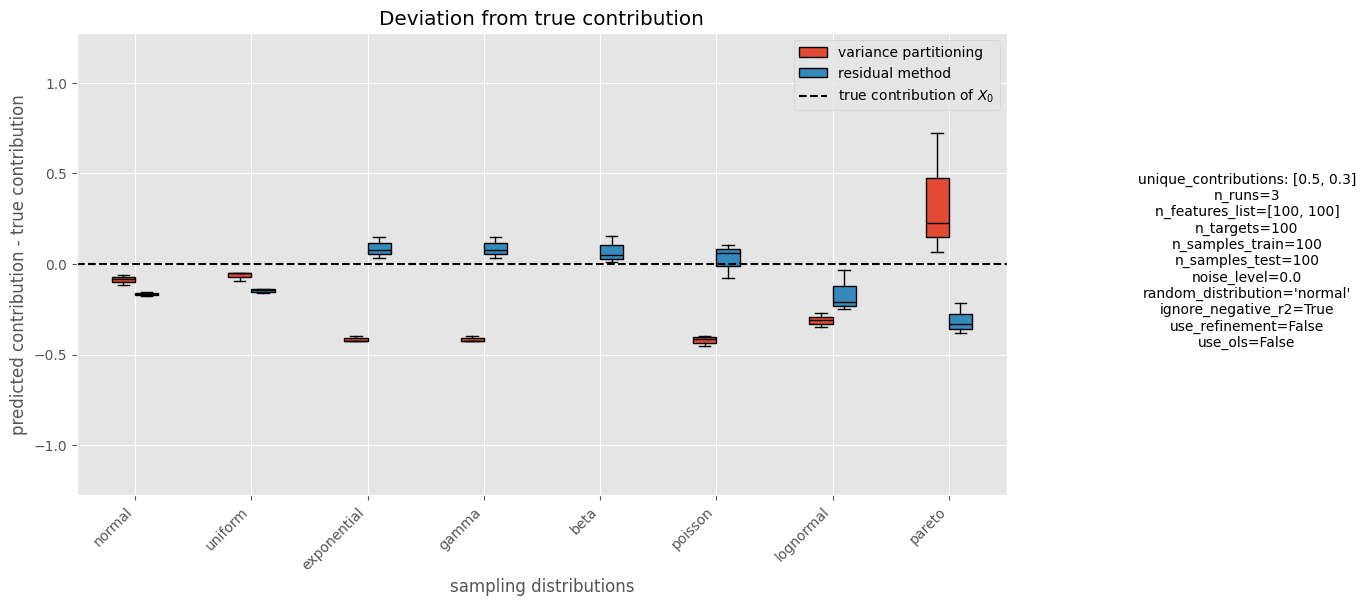

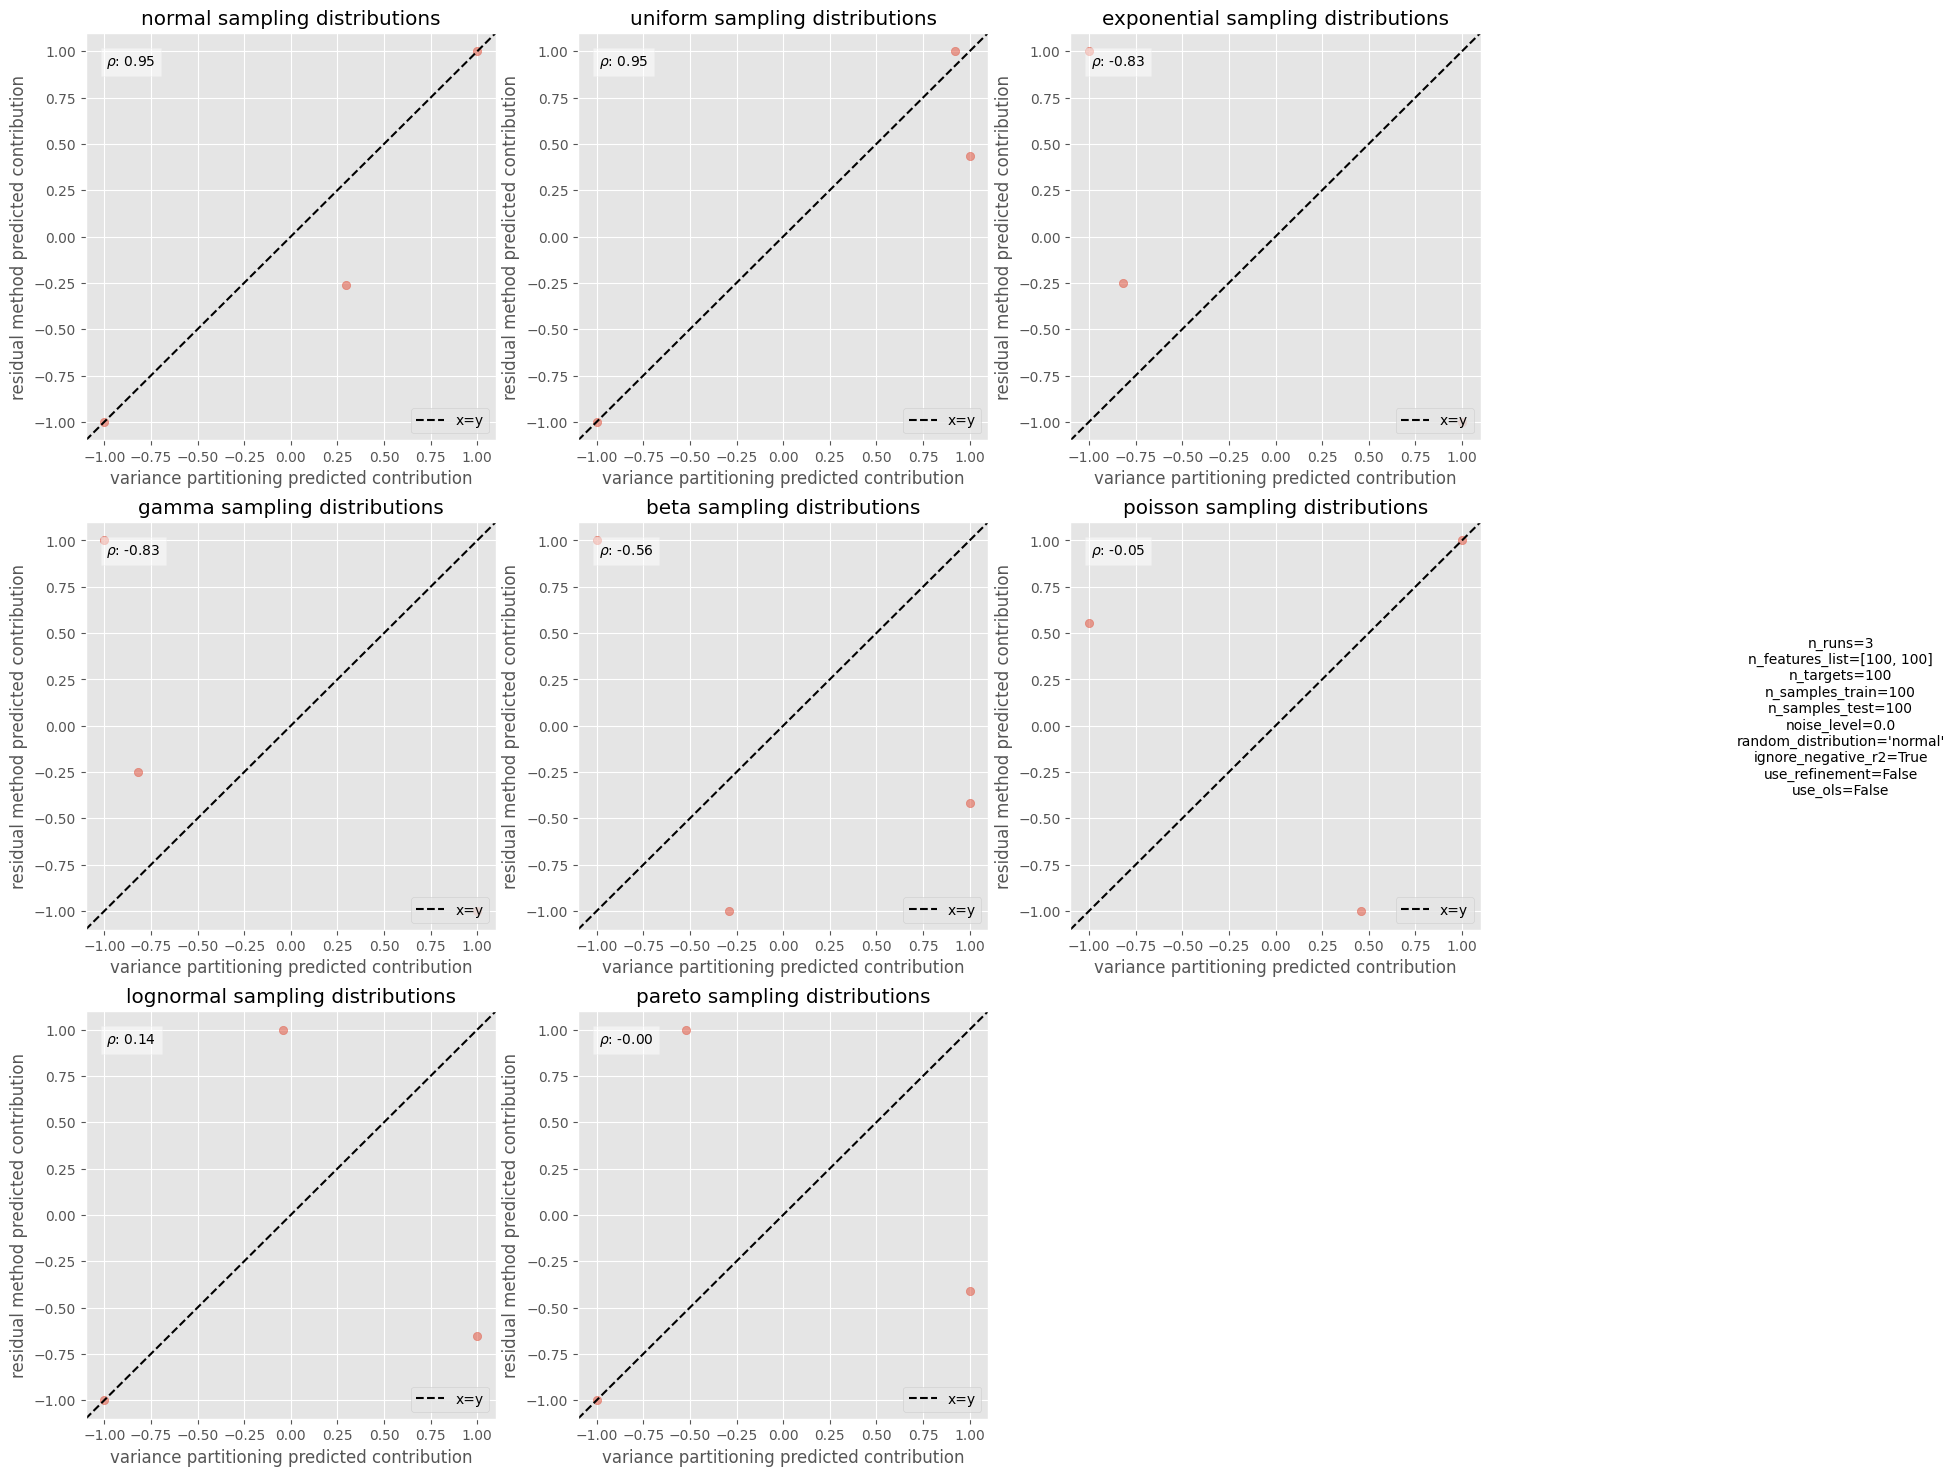

In [7]:
plot_experiment(random_distributions, variable_name, predicted_variance, predicted_residual, **variables)

# Test varying sample sizes

In [8]:
sample_sizes = np.logspace(1, 3, n_observations)

## varying train sample sizes

In [9]:
variable_name = "sample size training"

In [10]:
predicted_variance, predicted_residual = run_experiment(sample_sizes, variable_name, **variables)

[........................................] 100% | 9.75 sec | Varying sample size training | 


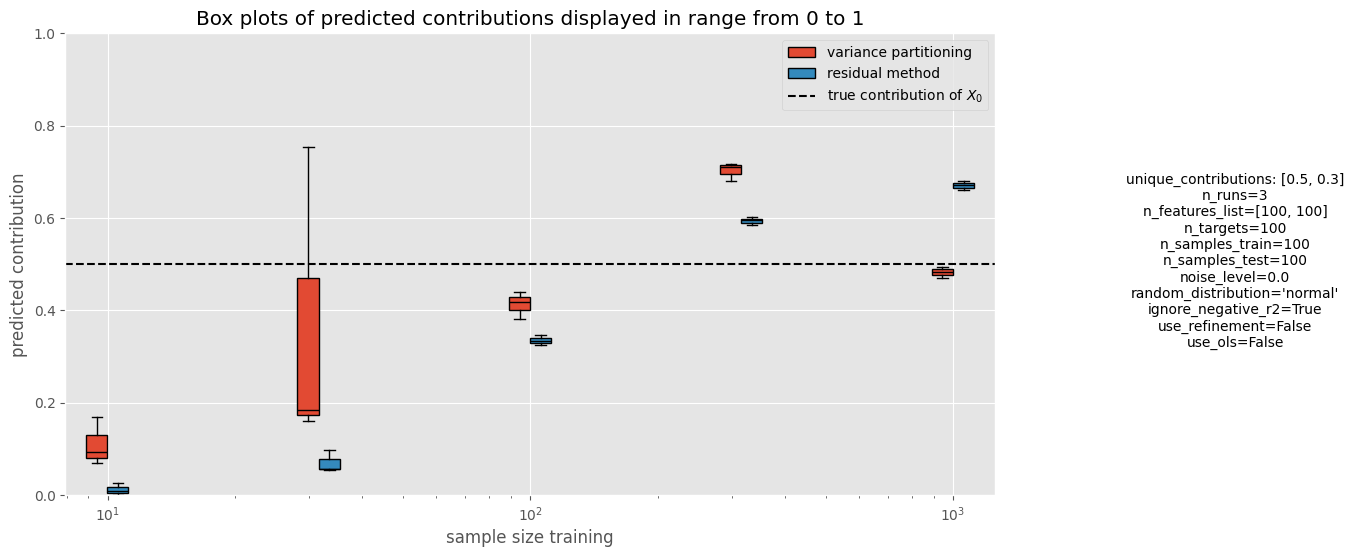

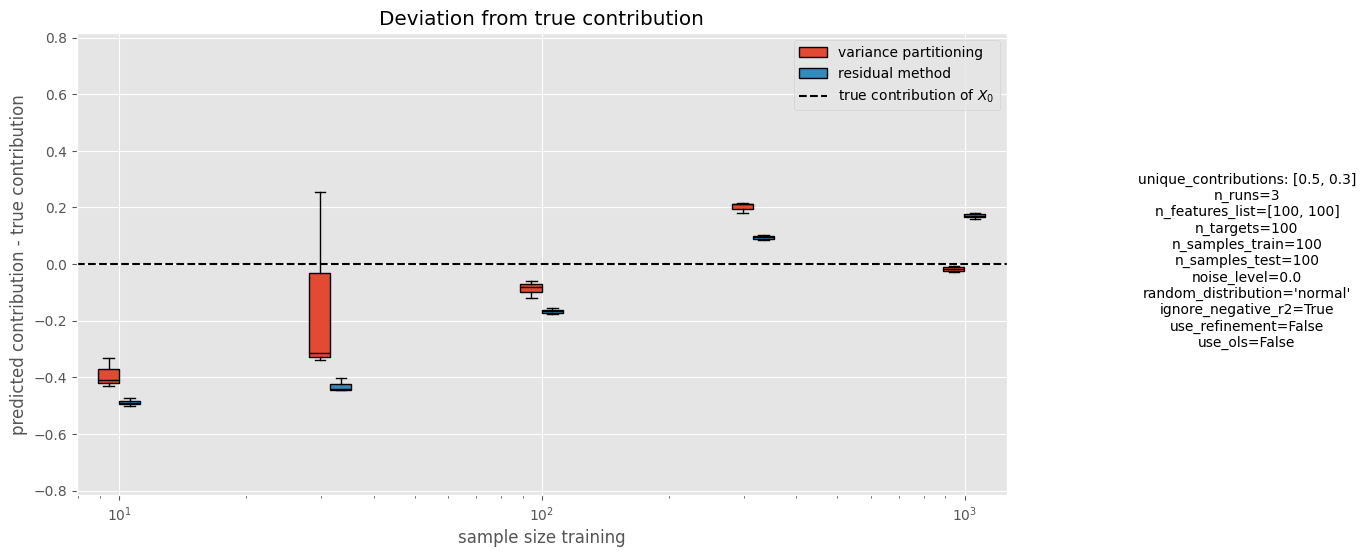

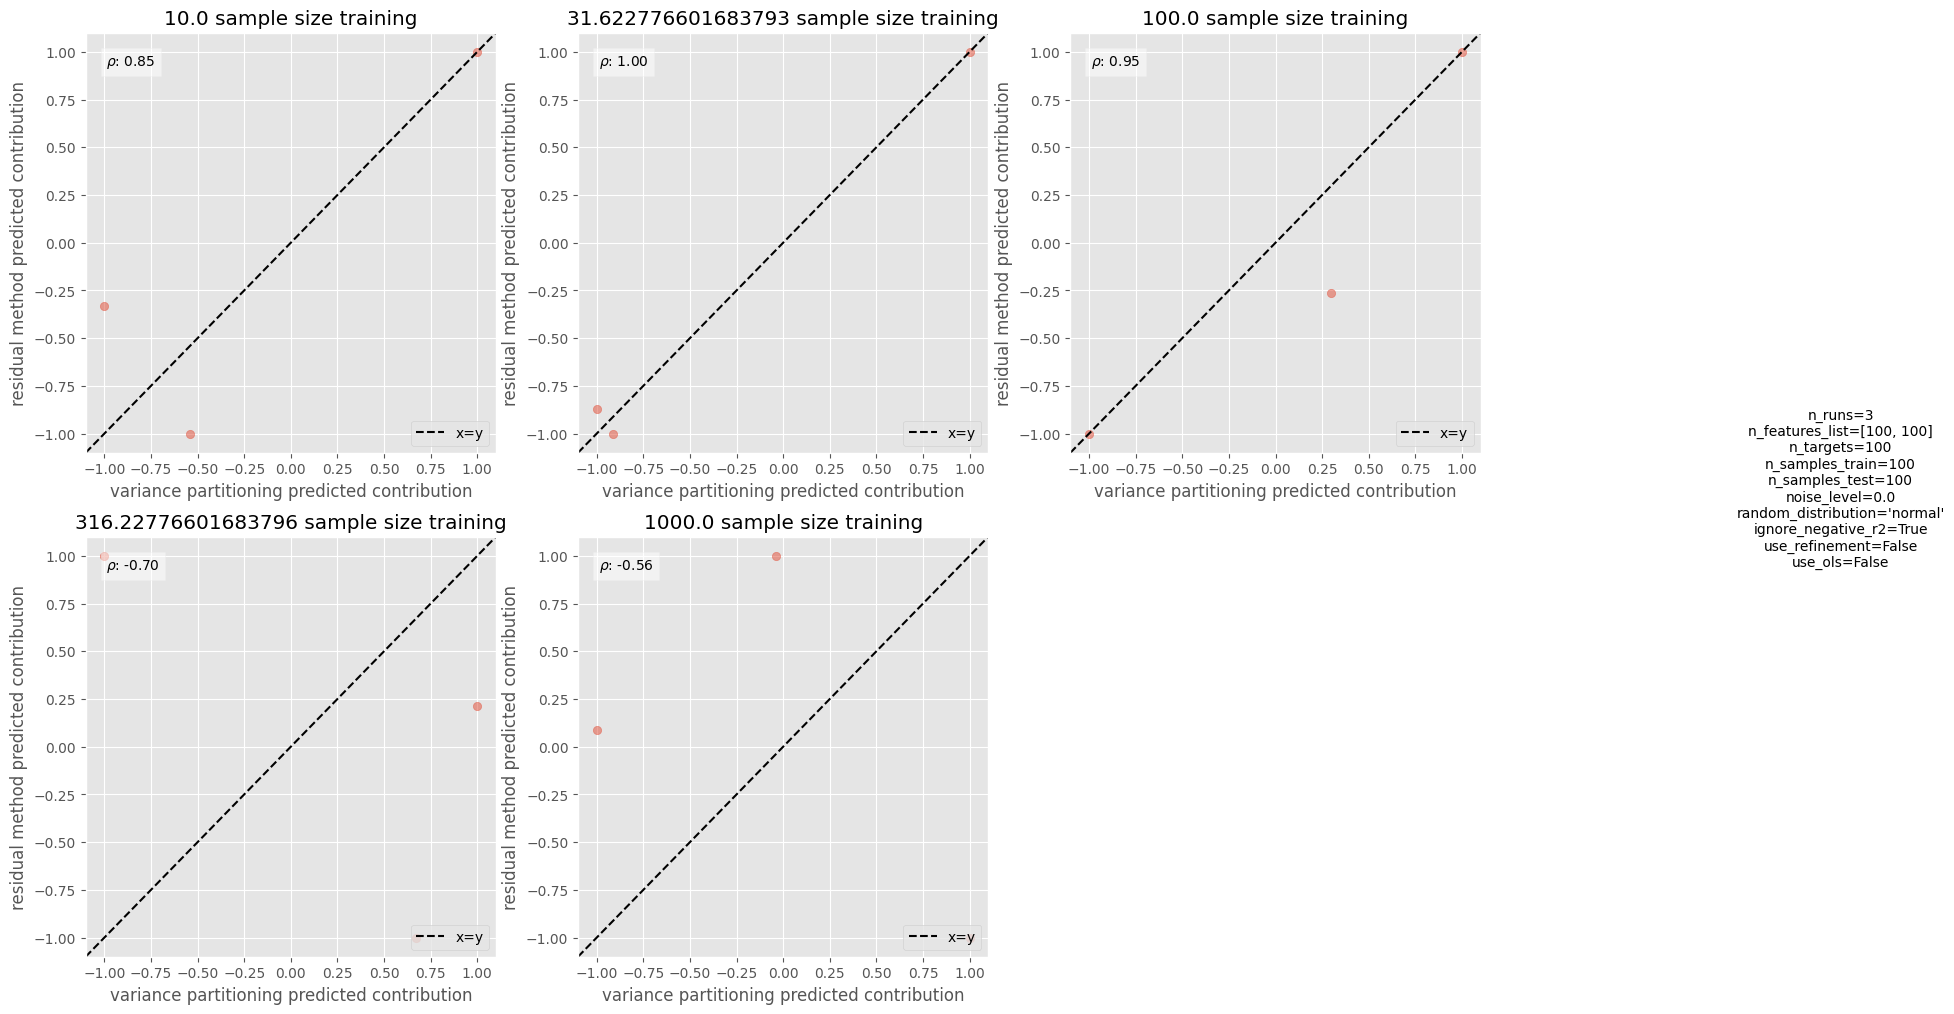

In [11]:
plot_experiment(sample_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

## varying test sample sizes

In [12]:
variable_name = "sample size testing"

In [13]:
predicted_variance, predicted_residual = run_experiment(sample_sizes, variable_name, **variables)

[........................................] 100% | 3.24 sec | Varying sample size testing | 


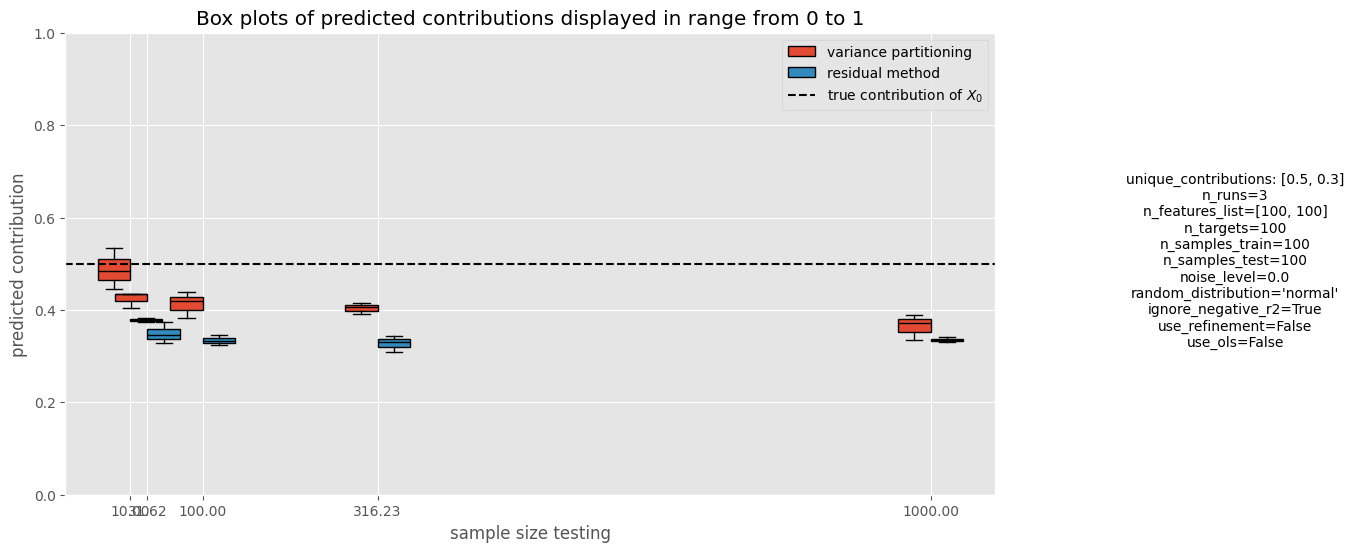

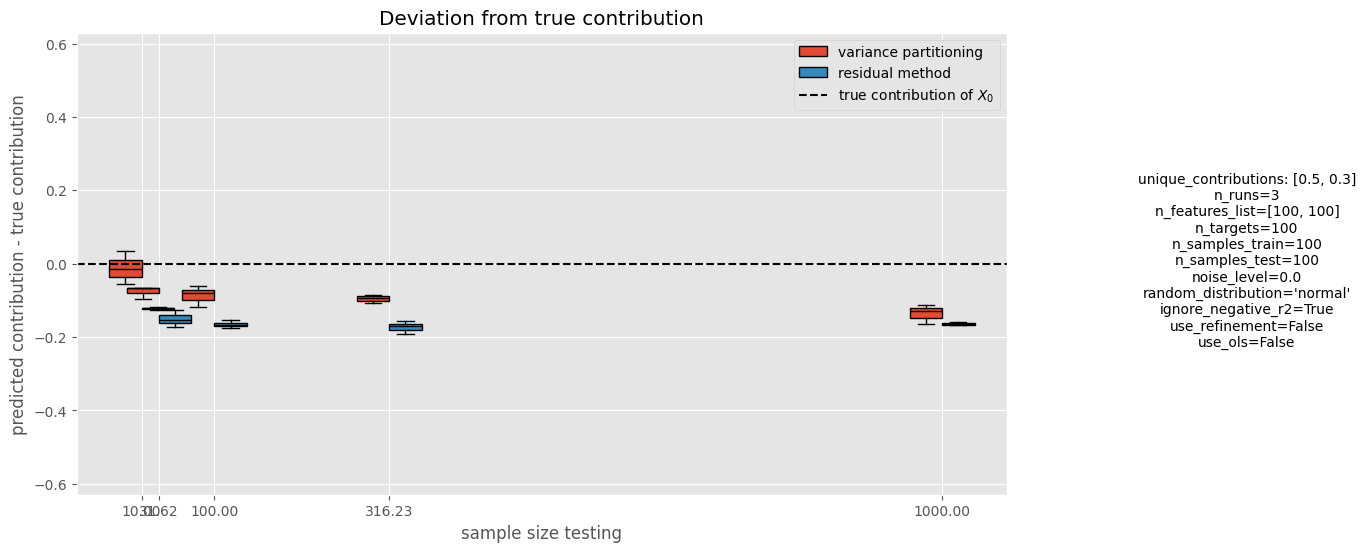

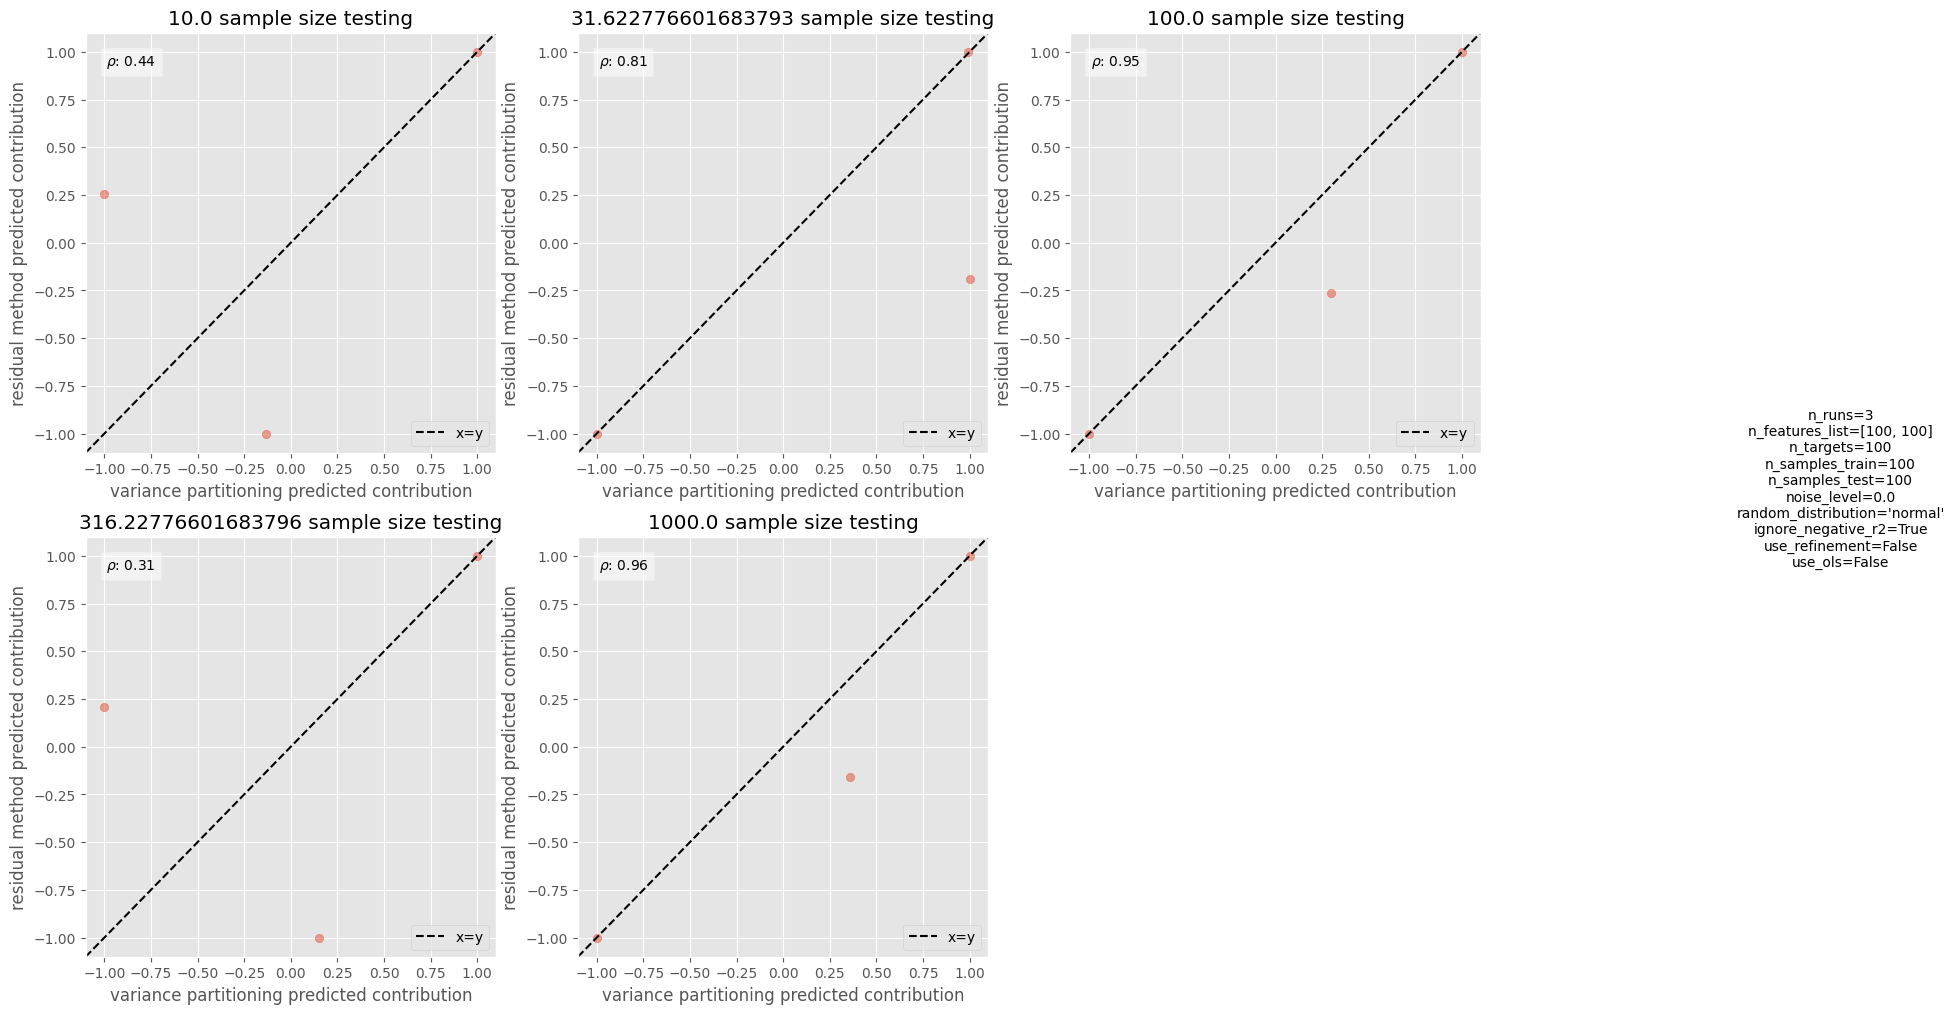

In [14]:
plot_experiment(sample_sizes, variable_name, predicted_variance, predicted_residual, **variables)

# Test varying feature sizes

In [15]:
feature_sizes = np.logspace(0, 4, n_observations)

## only $X_0$

In [16]:
variable_name = "number of features $X_{0}$"

In [17]:
predicted_variance, predicted_residual = run_experiment(feature_sizes, variable_name, **variables)

[........................................] 100% | 4.32 sec | Varying number of features $X_{0}$ | 


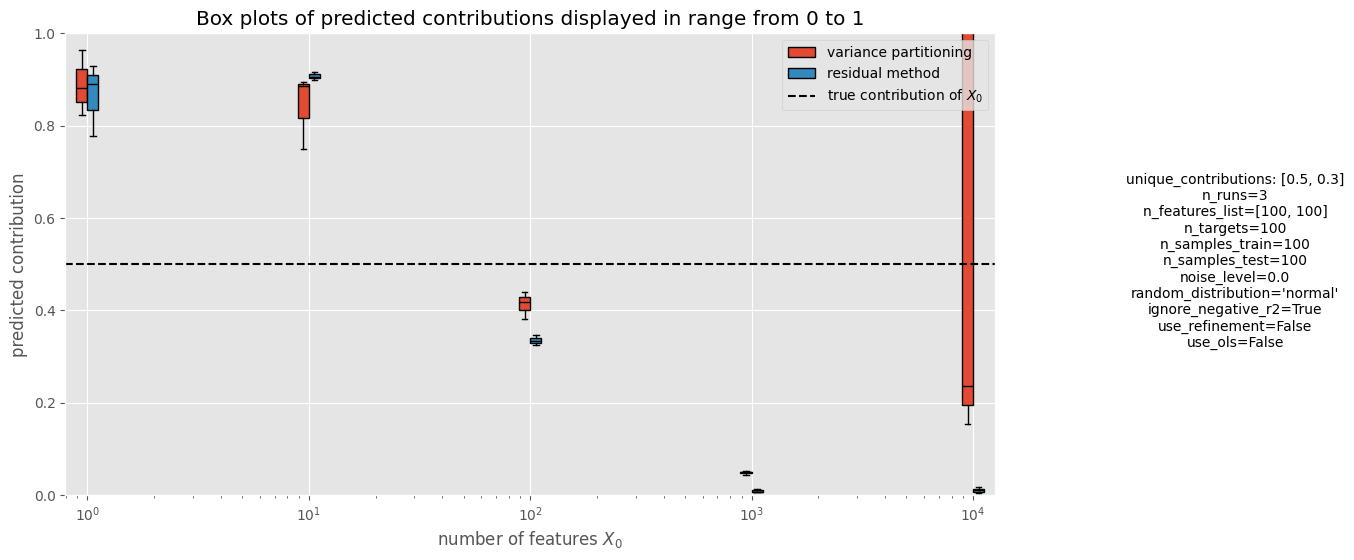

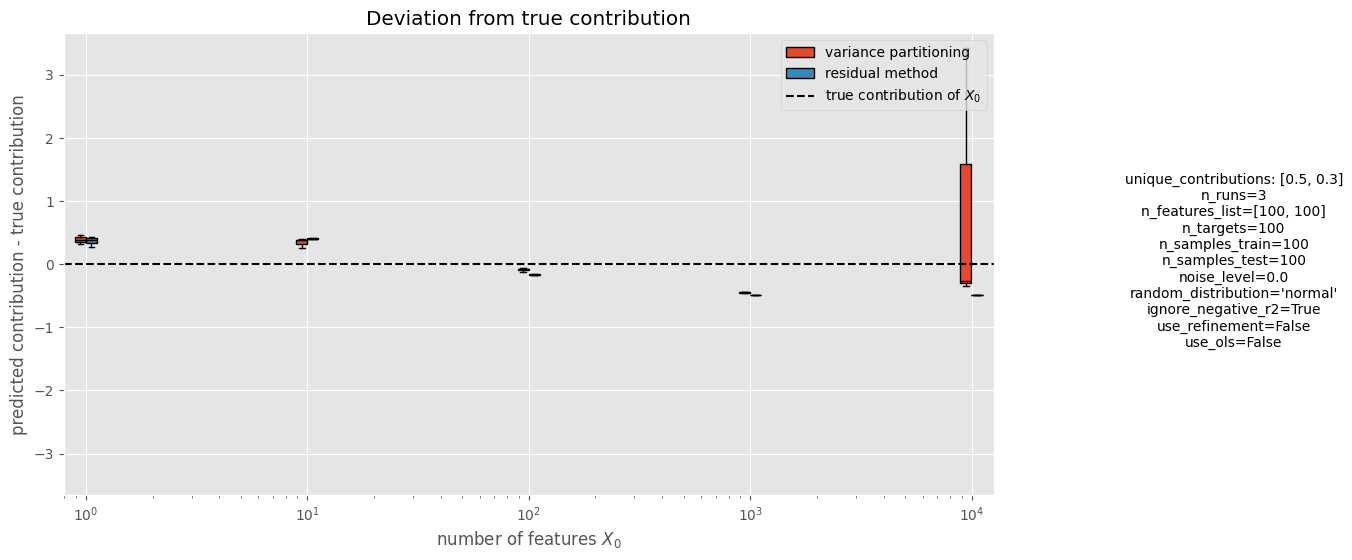

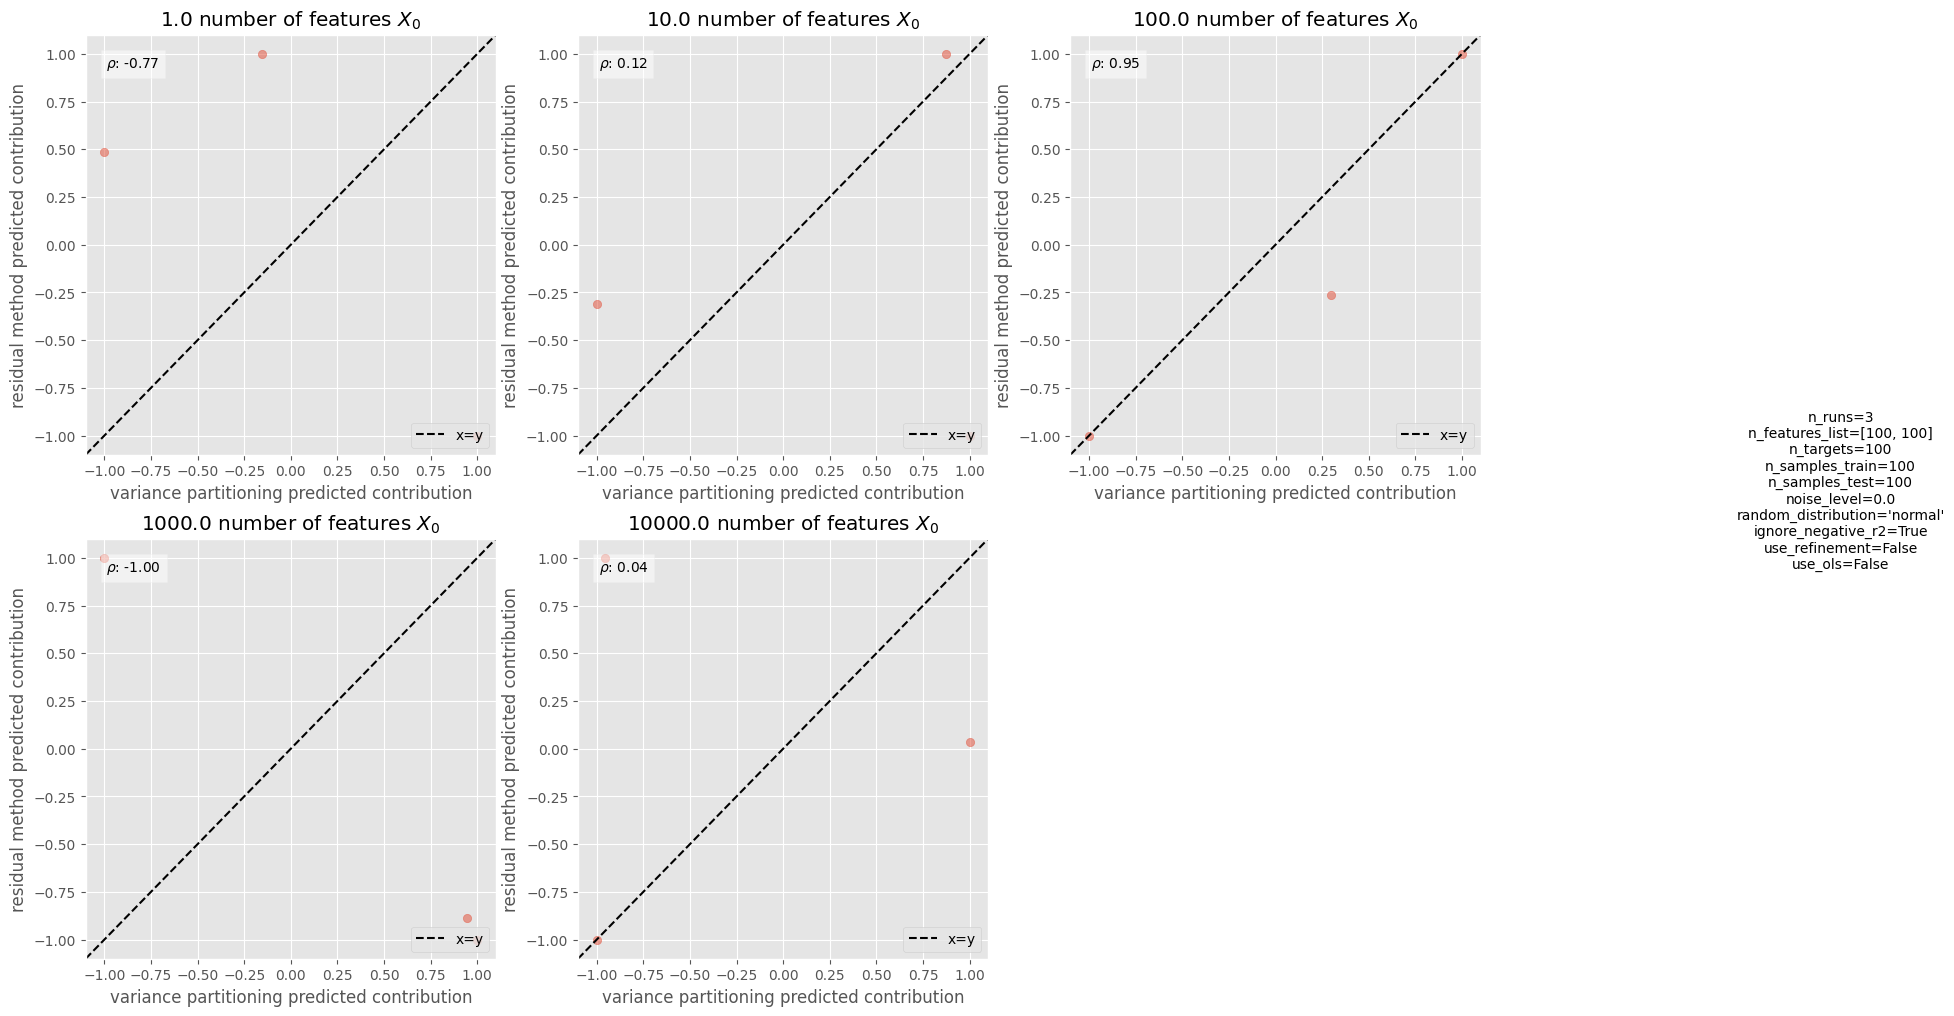

In [18]:
plot_experiment(feature_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

## both $X_0$ and $X_1$

In [19]:
variable_name = "number of features $X_{0,1}$"

In [20]:
predicted_variance, predicted_residual = run_experiment(feature_sizes, variable_name, **variables)

[........................................] 100% | 3.91 sec | Varying number of features $X_{0,1}$ | 


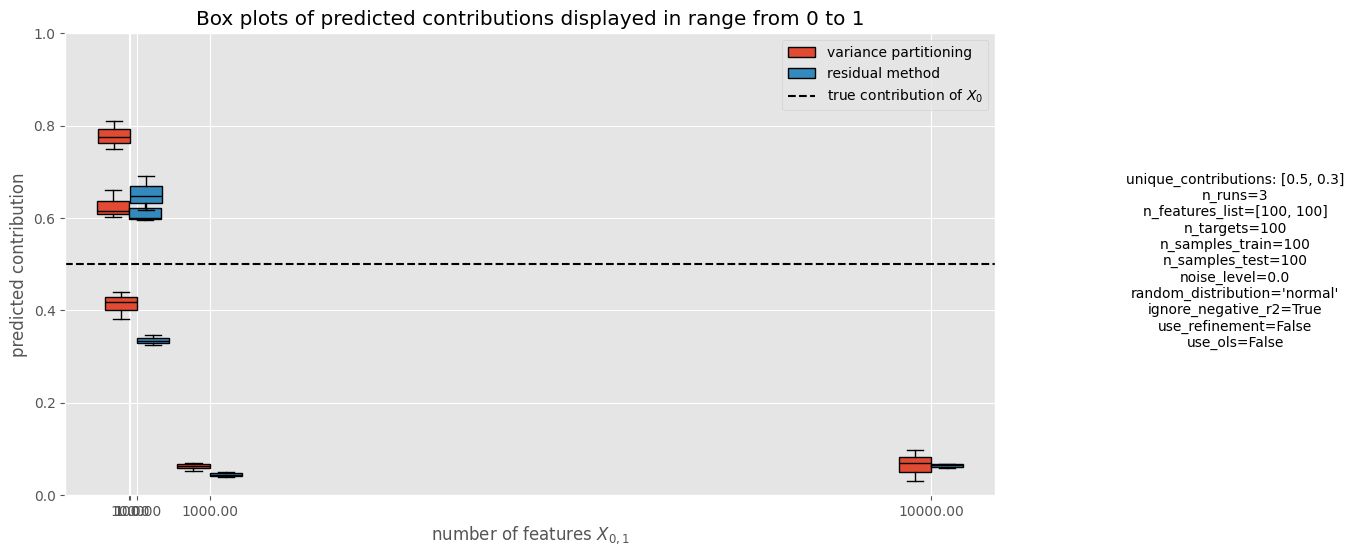

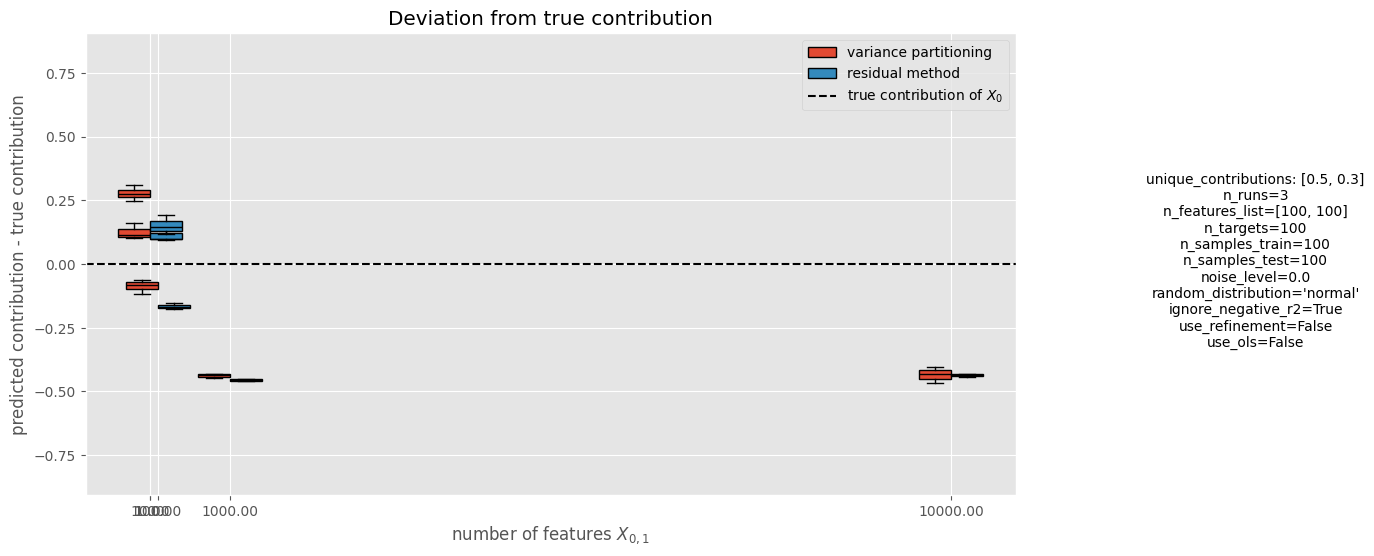

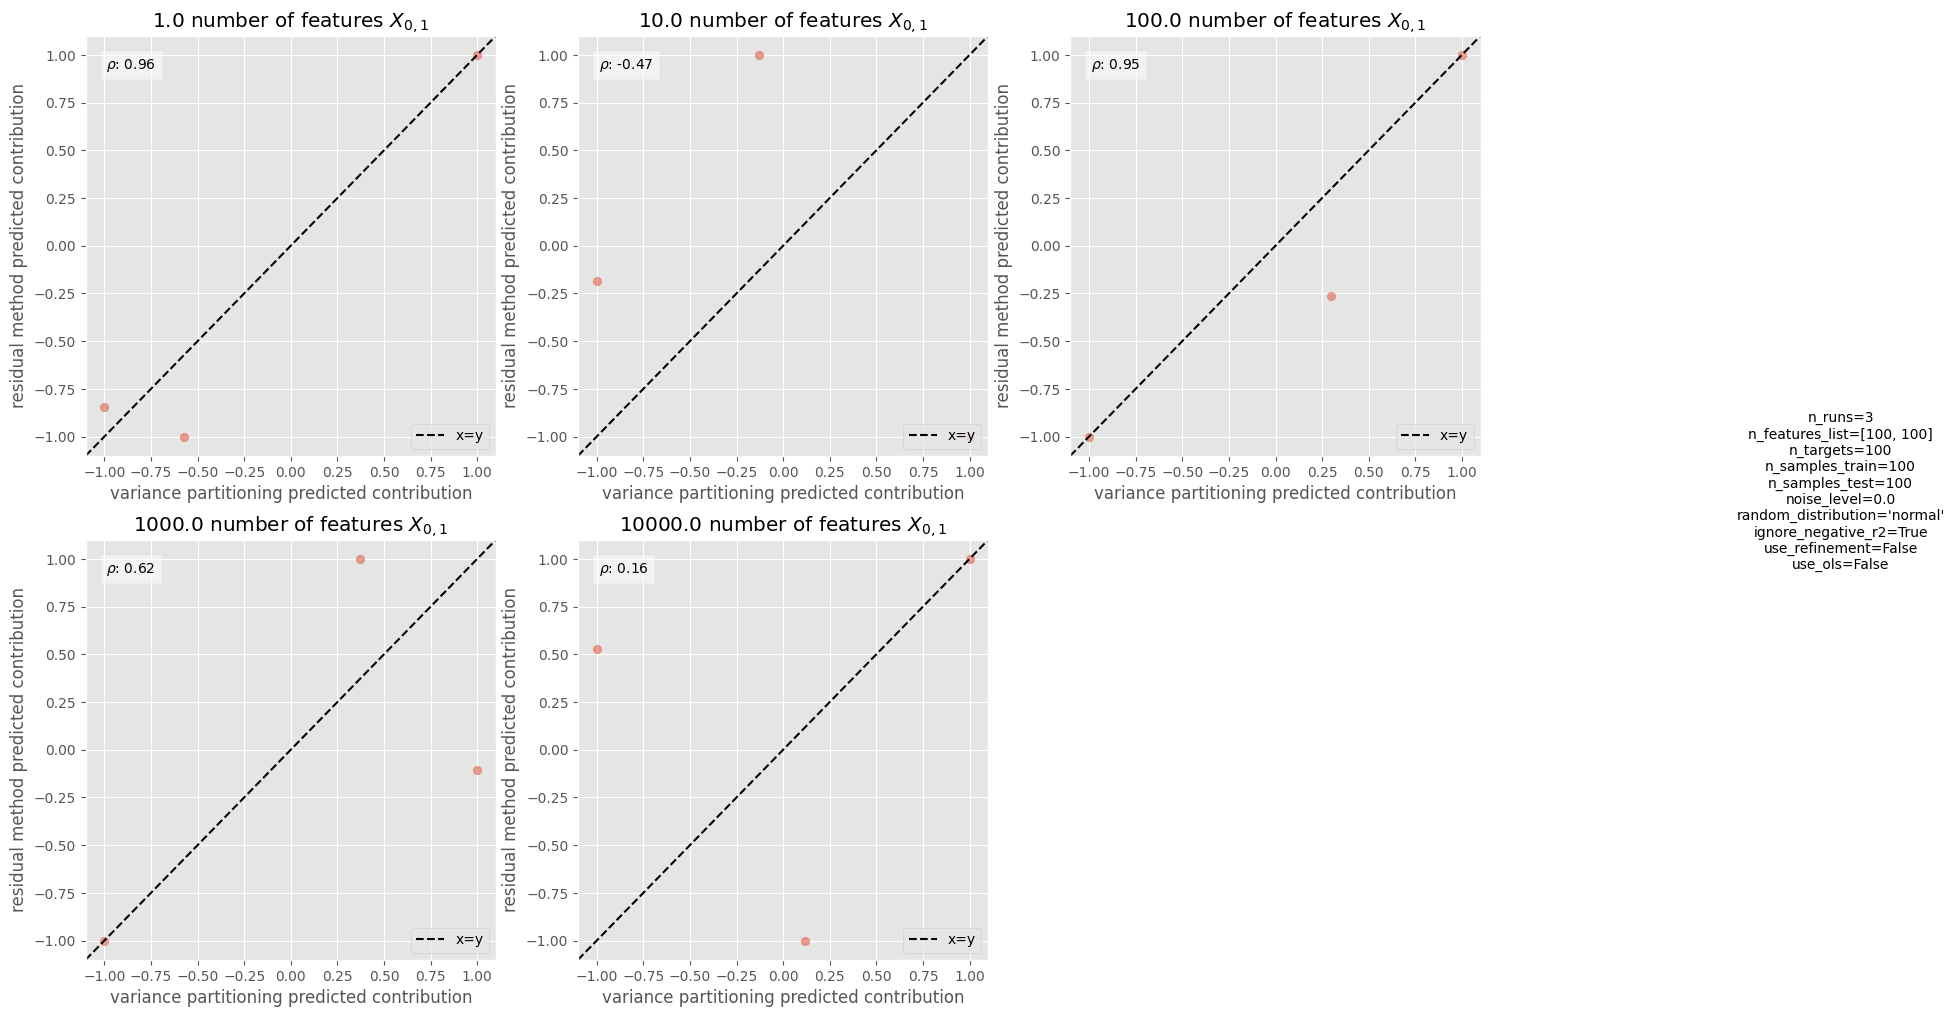

In [21]:
plot_experiment(feature_sizes, variable_name, predicted_variance, predicted_residual, **variables)

# varying target size

In [22]:
variable_name = "number of targets"
target_sizes = np.logspace(0, 4, n_observations)

In [23]:
predicted_variance, predicted_residual = run_experiment(target_sizes, variable_name, **variables)

[........................................] 100% | 5.34 sec | Varying number of targets | 


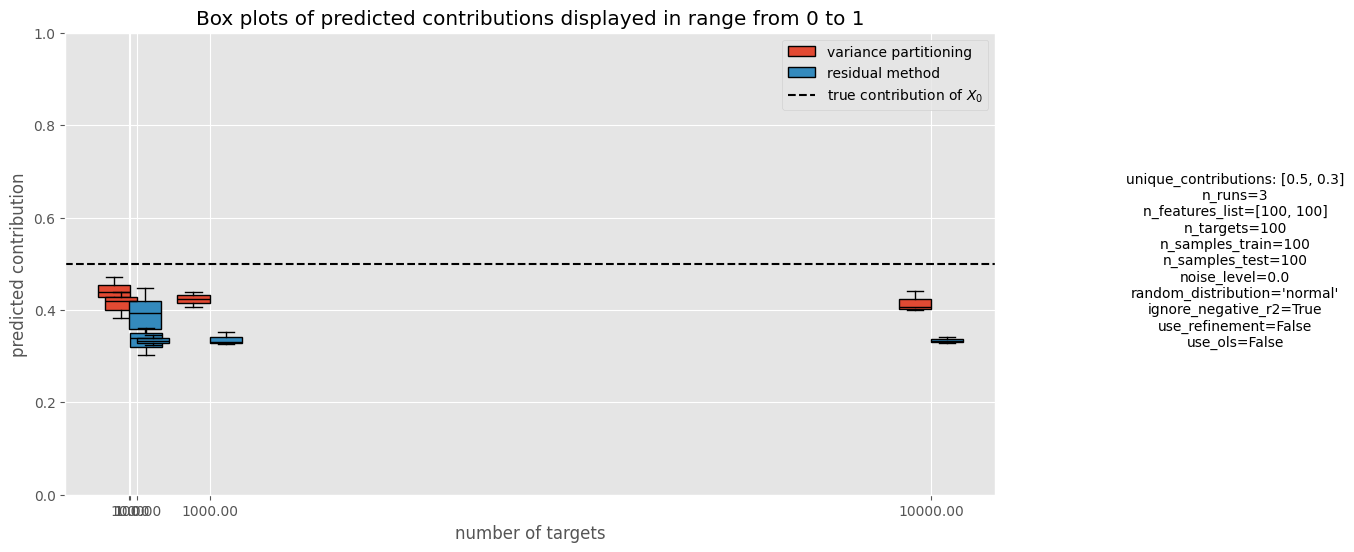

ValueError: Axis limits cannot be NaN or Inf

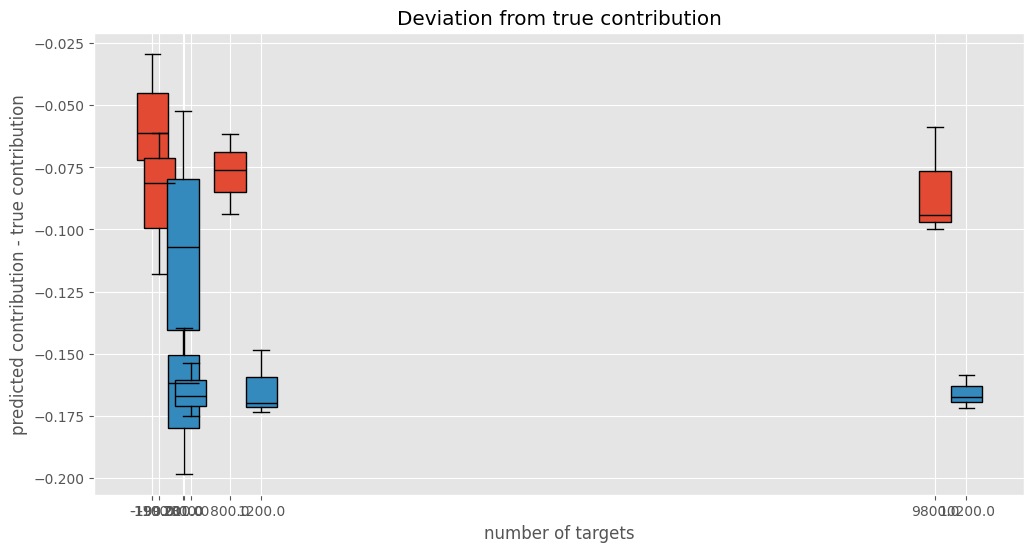

In [24]:
plot_experiment(target_sizes, variable_name, predicted_variance, predicted_residual, **variables)

# Test varying noise levels

In [ ]:
variable_name = "relative amount of noise in the target"
noise_levels = np.linspace(0, 1, n_observations)

In [ ]:
predicted_variance, predicted_residual = run_experiment(noise_levels, variable_name, **variables)

In [ ]:
plot_experiment(noise_levels, variable_name, predicted_variance, predicted_residual, **variables)

# Test varying unique contributions of $X_0$ and $X_1$

In [ ]:
variable_name = "proportions of unique contribution"
x0_unique_contributions = np.linspace(0, 1, n_observations)
# convert from np to python
x0_unique_contributions = [round(float(x), 2) for x in x0_unique_contributions]

In [ ]:
for x0_unique_contribution in x0_unique_contributions:
    contributions = [[x0_unique_contribution, round((1 - x0_unique_contribution) * x1 / (n_observations - 1), 2)] for
                     x1 in range(n_observations)]
    predicted_variance, predicted_residual = run_experiment(contributions, variable_name, **variables)
    plot_experiment(contributions, variable_name, predicted_variance, predicted_residual, **variables)